In [176]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import imutils
from scipy.spatial.distance import cdist
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.util import img_as_float
import matplotlib.patches as patches
from copy import deepcopy
%matplotlib inline

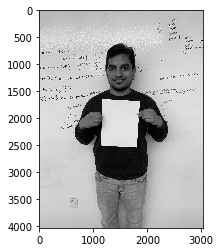

In [388]:
filename = '../images/rajeev.jpg'
img = cv2.imread(filename)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = 'gray')
plt.show()

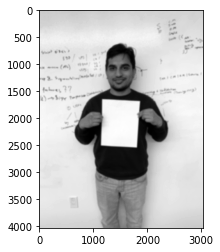

In [389]:
r = 75
img_gaussian = cv2.GaussianBlur(gray,(r,r),0)
plt.imshow(img_gaussian, cmap = 'gray')
plt.show()

In [390]:
r_img = imutils.resize(img, width=int(0.1*np.shape(img)[1]))

In [391]:
from skimage.filters import roberts

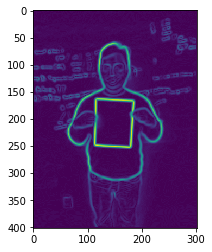

In [392]:
r = 9
r_img = imutils.resize(img, width=int(0.1*np.shape(img)[1]))
filt_img = cv2.GaussianBlur(r_img[:,:,0],(r,r),0)
img_roberts = roberts(filt_img)
plt.imshow(img_roberts)
img_roberts = cv2.normalize(src=img_roberts, dst=None, alpha=0, beta=255, 
               norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

In [393]:
#img_roberts.convertTo(img_roberts, CV_8UC1, 1/256.0)
cnts = cv2.findContours(img_roberts, mode = 3, method = 1)
cnts = cv2.findContours(img_roberts, cv2.RETR_EXTERNAL, 
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

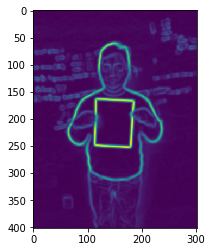

In [394]:
c_top, c_bottom = 20, 350
c_left, c_right = 50, 250
crop = img_roberts[c_top:c_bottom, c_left:c_right]
crop = img_roberts[:,:]
bi = cv2.bilateralFilter(crop, 5, 75, 75)
plt.imshow(bi)

In [395]:
dst = cv2.cornerHarris(bi, 2, 3, 0.04)

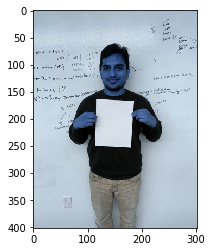

In [396]:
r_img_crop = r_img[c_top:c_bottom, c_left:c_right]
r_img_crop = r_img[:,:]
mask = np.zeros_like(r_img_crop)

corners = dst > 0.1*dst.max()
plt.imshow(r_img_crop)

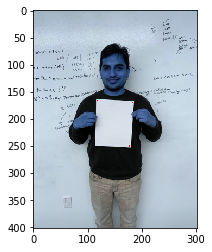

In [397]:
r_img_copy = deepcopy(r_img[c_top:c_bottom, c_left:c_right,:])
r_img_copy = deepcopy(r_img[:,:,:])
r_img_copy[corners] = [255,0,0]
plt.imshow(r_img_copy)

In [398]:
corners_loc = np.where(corners)
xy_corners = list(zip(corners_loc[1], corners_loc[0]))
xy_corners
index = list(range(0, len(xy_corners)))

In [399]:
prelim_dist = cdist(xy_corners, xy_corners)
prelim_dist[0]

array([  0.        ,   1.        ,   1.41421356,   2.23606798,
        65.06919394,  64.12487817,  65.12296062,  64.19501538,
        68.68041933,  68.9637586 ,  80.00624976,  81.0246876 ,
        81.0061726 , 101.25709852, 101.83319694, 102.6498904 ,
       103.2279032 , 103.46980236, 104.04326023])

In [400]:
from itertools import combinations
index_combinations = list(combinations(index, 4))
len(index_combinations)

3876

In [403]:
def getXYforIndices(all_x, all_y, indices):
    x = []
    y = []
    for index in indices:
        x.append(all_x[index])
        y.append(all_y[index])
    return x, y

In [411]:
xy_combinations = []
for comb in index_combinations:
    xy_combinations.append(getXYforIndices(corners_loc[1], corners_loc[0], comb))

In [412]:
to_remove = []

for xy_comb in xy_combinations:
    xy_distances = cdist(list(zip(xy_comb[0], xy_comb[1])), 
          list(zip(xy_comb[0], xy_comb[1])))
    not_rectangular = np.where((xy_distances > 0) & (xy_distances <= 5))
    
    if len(not_rectangular[0]) or len(not_rectangular[1]): 
        to_remove.append(xy_comb)
        
for r in to_remove:
    xy_combinations.remove(r)
xy_combinations

[([118, 183, 184, 117], [166, 169, 185, 246]),
 ([118, 183, 184, 116], [166, 169, 185, 247]),
 ([118, 183, 184, 117], [166, 169, 185, 247]),
 ([118, 183, 184, 176], [166, 169, 185, 249]),
 ([118, 183, 184, 177], [166, 169, 185, 249]),
 ([118, 183, 184, 177], [166, 169, 185, 250]),
 ([118, 183, 184, 178], [166, 169, 185, 250]),
 ([118, 183, 184, 177], [166, 169, 185, 251]),
 ([118, 183, 184, 178], [166, 169, 185, 251]),
 ([118, 183, 184, 117], [166, 169, 186, 246]),
 ([118, 183, 184, 116], [166, 169, 186, 247]),
 ([118, 183, 184, 117], [166, 169, 186, 247]),
 ([118, 183, 184, 176], [166, 169, 186, 249]),
 ([118, 183, 184, 177], [166, 169, 186, 249]),
 ([118, 183, 184, 177], [166, 169, 186, 250]),
 ([118, 183, 184, 178], [166, 169, 186, 250]),
 ([118, 183, 184, 177], [166, 169, 186, 251]),
 ([118, 183, 184, 178], [166, 169, 186, 251]),
 ([118, 183, 117, 176], [166, 169, 246, 249]),
 ([118, 183, 117, 177], [166, 169, 246, 249]),
 ([118, 183, 117, 177], [166, 169, 246, 250]),
 ([118, 183, 

In [421]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [422]:
largest_area = 0
best_rectangle = ([],[])
for xy_comb in xy_combinations:
    area = PolyArea(xy_comb[0], xy_comb[1])
    if area > largest_area:
        largest_area = area
        best_rectangle = (xy_comb[0], xy_comb[1])

In [428]:
best_rectangle
print(best_rectangle[0])


[118, 183, 184, 116]


162.0


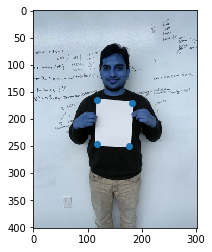

In [430]:
fig, ax = plt.subplots(1)

# Display the image
#best_rectangle = ([118, 183, 184, 116], [166, 169, 186, 247])
best_rectangle = ([118, 182, 117, 177], [166, 170, 247, 251])
print(PolyArea(best_rectangle[0], best_rectangle[1]))
ax.imshow(r_img_crop)
plt.scatter(best_rectangle[0], best_rectangle[1])
plt.show()